In [1]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pystan
import seaborn as sns
import arviz as az
import corner
import time

In [2]:
data=pd.read_csv("CRO-HIV-AIDS.csv",header=None)

In [3]:
y_obs_tmp=data[[1,2]]
y_obs=y_obs_tmp.to_numpy()

In [4]:
#az.style.use("arviz-darkgrid")


NumIter = 10000
burnin  = 5000



save_results_to = 'CRO_hypothTest/'

times = np.linspace(0, y_obs.shape[0]-1, y_obs.shape[0])
N=len(times)
small_times = np.linspace(0, N-1 ,10*N+1)


pred_days  = N+2
times_pred = np.linspace(0, pred_days,pred_days +1 ) 
times_pred_small = np.linspace(0, pred_days,(pred_days+1)*10 +1 ) 

pop = 4076246         # Population 

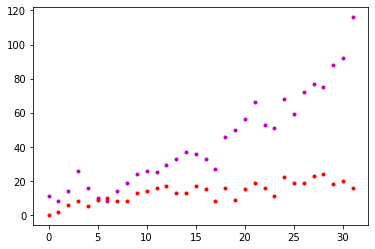

In [5]:
fig0= plt.figure()
plt.plot(times, y_obs[:,0],'m.', times, y_obs[:,1],'r.')
#plt.show()
plt.savefig( save_results_to + 'HIV-AIDS_cases.eps')

In [6]:
mydata = {}
mydata['n_obs']       = len(times)
mydata['n_small']     = len(small_times)
mydata['n_small_pred']= len(times_pred_small)
mydata['n_theta']     = 4
mydata['n_difeq']     = 3
mydata['n_pop']       = pop
mydata['y']           = y_obs
mydata['t0']          = -0.000001
mydata['n_fake']      = len(times_pred)
mydata['fake_ts']     = times_pred_small
mydata['tsm']         = small_times
mydata['ts']          = times

In [7]:
beta_mu = 0.
beta_sd = 1.
beta_stan = 'lognormal({mu}, {sigma})'.format(mu=beta_mu, sigma=beta_sd)


beta_exp = 5.
R0_stan = 'exponential({beta})'.format(beta=beta_exp)


sigma_low  = 0
sigma_high = 1
sigma_stan = 'uniform({mu}, {sd})'.format(mu=sigma_low, sd=sigma_high)


Karga1_low  = 0
Karga1_high = 30
Karga1_stan = 'uniform({mu}, {sd})'.format(mu=Karga1_low, sd=Karga1_high)


Karga2_low  = 0
Karga2_high = 30
Karga2_stan = 'uniform({mu}, {sd})'.format(mu=Karga2_low, sd=Karga2_high)

I0_low  = 0.
I0_high = 8e-5
I0_stan = 'uniform({mu}, {sd})'.format(mu=I0_low, sd=I0_high)


A0_low  = 0.
A0_high = 8e-5
A0_stan = 'uniform({mu}, {sd})'.format(mu=A0_low, sd=A0_high)

In [8]:
# Fit
stan_code = """
functions {{
  real[] SIR(real t,  // time
  real[] y,           // system state {{susceptible,infected,recovered}}
  real[] theta,       // parameters
  real[] x_r,
  int[] x_i) {{
  
  real mu= 0.0089;
  real nu= 0.0129;



  real xi1     =  1e-5;
  real xi2     =  1e-6;
  real kappa  =  0.00003;
  
  real beta   = theta[1];
  real sigma  = theta[2];
  real Karga1 = theta[3];
  real Karga2 = theta[4];
  
  real dy_dt[3];
  
  dy_dt[1] =  mu -(beta*y[2] + nu + xi1  )*y[1];
  dy_dt[2]  =(beta* y[2] + xi1 ) *y[1] - (sigma + nu  - xi2)*y[2];
  dy_dt[3] = (sigma -xi2)* y[2] - (kappa + nu)*y[3];
  
  return dy_dt;
  }}
  
  }}
  data {{
  
  int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_small;       // number of days observed
  int<lower = 1> n_small_pred;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations
  int<lower = 1> n_pop;       // population 
  int y[n_obs,(n_difeq-1)];           // data, total number of infected individuals each day
  real t0;                // initial time point (zero)
  real ts[n_obs];         // time points observed
  real tsm[n_small];         // time points observed
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  real fake_ts[n_small_pred]; // Time points for "predicted"/"unsampled" data
  
  }}
  
  transformed data {{
  real x_r[0];
  int x_i[0];
  }}
  
  parameters {{

//  real<lower =  0, upper = 1.> beta ;
  real<lower =  0, upper = 1.> sigma ;
  real<lower =  1> R0 ;
  real<lower =  0, upper = 30.> Karga1 ;
  real<lower =  0, upper = 30.> Karga2 ;


  
  }}
  
  transformed parameters{{
  
  real y_hat[n_obs,(n_difeq-1)]; // solution from the ODE solver
  real y_hat_sm[n_small, n_difeq]; // solution from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I
  real theta[n_theta];   // {{ alpha, beta, gamma, delta }}
  
  real S0;
  real I0;
  real A0;
  real lambda1[n_obs];
  real lambda2[n_obs];
  real rho1[n_obs]; 
  real rho2[n_obs];
  vector[11] weights;
  vector[11] incidence1;
  vector[11] incidence2;
  real dt=1./(10*n_obs);
  real xi1=1e-5;
  real xi2=1e-6;  
//  real nu= 0.0129;
  real beta = R0 * (sigma + 0.0129);

  
  S0 = 0.999997301;
  I0 = 0.000002699;
  A0 = 0.;

  y_init[1] = S0;
  y_init[2] = I0;
  y_init[3] = A0;
  
  
  
  
  theta[1] = beta;
  theta[2] = sigma;
  theta[3] = Karga1;
  theta[4] = Karga2;

  
  y_hat_sm = integrate_ode_rk45(SIR, y_init, t0, tsm, theta, x_r, x_i);

  
 weights[1] =0.5;
 weights[11]=0.5;
 
 for (i in 2:10){{
     weights[i] = 1.0;
  }}

 
  for (i in 1:n_obs){{
      lambda1[i] = 0.0;
      lambda2[i] = 0.0;
      for (k in 1:11){{
       incidence1[k] = (beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incidence2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];
       lambda1[i]    = lambda1[i] + dt*weights[k]*incidence1[k];
       lambda2[i]    = lambda2[i] + dt*weights[k]*incidence2[k];
      }}
  y_hat[i,1]=n_pop*Karga1*lambda1[i];
  y_hat[i,2]=n_pop*Karga2*lambda2[i];
 }}
    


  }}
  
  
  model {{
  
  real lamb1[n_obs];      //poisson parameter
  real lamb2[n_obs];      //poisson parameter
  real rhho1[n_obs];      //poisson parameter
  real rhho2[n_obs];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_obs);
  real xii1 =1e-5;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  //priors
//  beta     ~ lognormal(0, 1.);
  R0       ~ exponential(5);
  sigma    ~ uniform(0.0, 1.0 );
  Karga1   ~ uniform(0.0, 30 );
  Karga2   ~ uniform(0.0, 30);

  
  
  //likelihood
  for (i in 1:(n_obs)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( beta*y_hat_sm[k + 10*(i-1),2] + xii1 )*y_hat_sm[k + 10*(i-1),1];
       incid2[k] = ( sigma- xii2 )*y_hat_sm[k + 10*(i-1),2];       
       lamb1[i]    = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]    = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i] = n_pop*Karga1*lamb1[i];
  rhho2[i] = n_pop*Karga2*lamb2[i]; 
  y[i , 1] ~ poisson(rhho1[i]);
  y[i , 2] ~ poisson(rhho2[i]);
  }}
 
  }}
  
  generated quantities {{

  real nu= 0.0129;
  real epsilon = 1e-9;
  real fake[n_fake, 2];
  real <lower = 0.> y_hat_pred[n_small_pred, n_difeq]; // Output from the ODE solver
  
  real lamb1[n_fake];      //poisson parameter
  real lamb2[n_fake];      //poisson parameter
  real rhho1[n_fake];      //poisson parameter
  real rhho2[n_fake];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_fake);
  real xii1 =1e-5;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  y_hat_pred = integrate_ode_rk45(SIR, y_init, t0, fake_ts, theta, x_r, x_i);  
  
    //likelihood
  for (i in 1:(n_fake)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( theta[1]*y_hat_pred[k + 10*(i-1),2] + xii1 )*y_hat_pred[k + 10*(i-1),1];
       incid2[k] = ( theta[2]- xii2 )*y_hat_pred[k + 10*(i-1),2];       
       lamb1[i]   = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]   = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i]=n_pop*theta[3]*lamb1[i];
  rhho2[i]=n_pop*theta[4]*lamb2[i];
  fake[i , 1] = poisson_rng( rhho1[i] );
  fake[i , 2] = poisson_rng( rhho2[i] );
 
  }}
  
  
//  R_0 = theta[1]/(theta[2] + nu);
  }}
""".format(
        R0     =R0_stan,
        sigma  =sigma_stan,
        Karga1 =Karga1_stan,
        Karga2 =Karga2_stan
        )

In [9]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2fd50f6ac1bd34fbe9155313aa07ead2 NOW.


--- 38.652528047561646 seconds ---


In [10]:
# do the fitting
start_time = time.time()
fit = sm.sampling(
                  data=mydata,
                  iter=NumIter,
                  chains=6,
                  warmup=burnin,
                  seed=431,
                  verbose=True,
                  algorithm='NUTS',
                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--- 154.6084382534027 seconds ---


In [11]:
varnames = ["beta", "sigma", "Karga1", "Karga2","R0"]
summary=fit.summary(pars=varnames, probs=(0.025, 0.25, 0.5, 0.75, 0.975))

In [12]:
df_summary =  pd.DataFrame(
    summary['summary'],
    columns=summary['summary_colnames'],
    index=summary['summary_rownames']
)

fit_dict= fit.extract()
fit_df = fit.to_dataframe()

In [13]:
fit_dict= fit.extract()
fit_df = fit.to_dataframe()
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,0.300873,0.000921,0.064366,0.195170,0.254468,0.293911,0.339703,0.443752,4882.249169,1.001063
sigma,0.241270,0.000897,0.062623,0.136784,0.196069,0.235101,0.279203,0.378576,4874.086834,1.001088
Karga1,4.997943,0.011608,0.867482,3.419636,4.391328,4.954413,5.559711,6.828880,5584.645152,1.000758
Karga2,2.171411,0.007574,0.550976,1.300858,1.773832,2.101216,2.485404,3.442223,5291.811446,1.000879
R0,1.194078,0.000676,0.051423,1.120109,1.157687,1.185362,1.221173,1.318281,5787.899058,1.000964


In [14]:
#print(fit)

In [15]:
# with open('Table_BR_C.tex','w') as tf:
#      tf.write(df_summary.to_latex())

In [16]:
data = az.from_pystan(
    posterior=fit,
    posterior_predictive="fake",
    observed_data=["y"],
)

data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> observed_data

<Figure size 432x288 with 0 Axes>

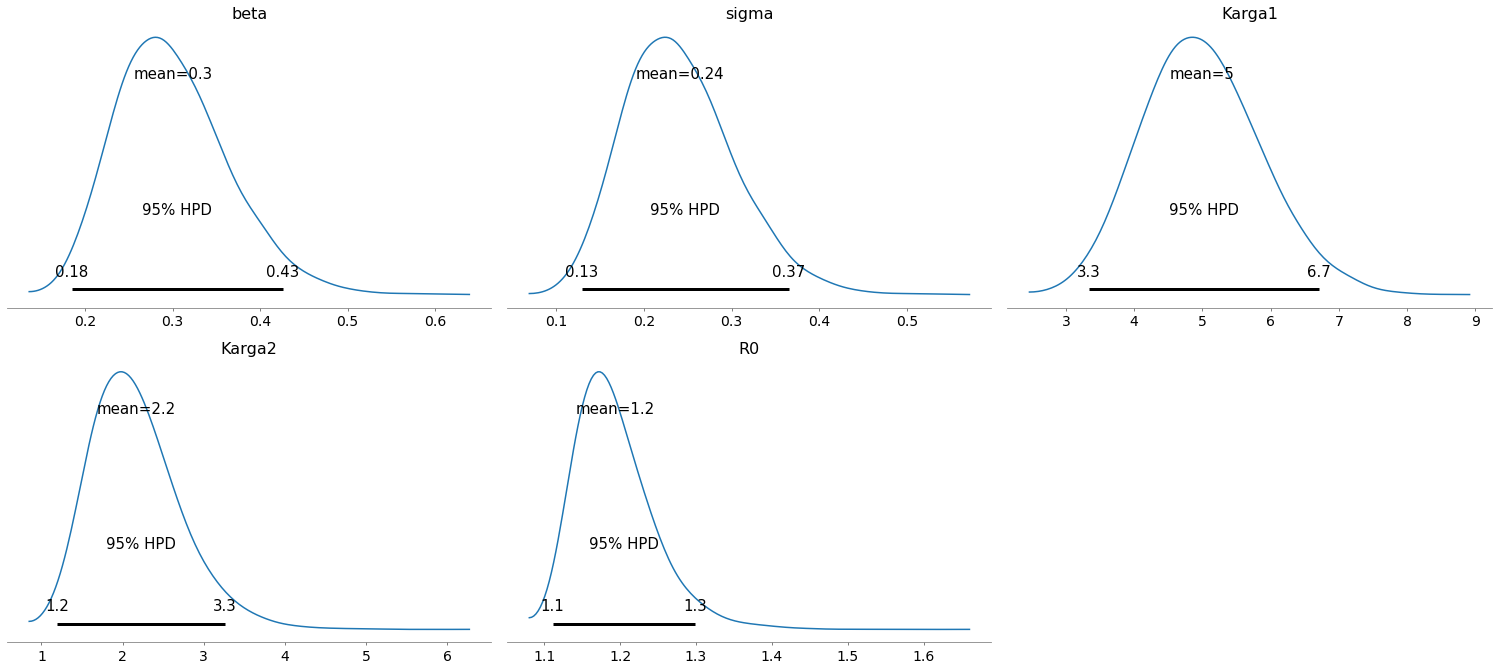

In [17]:
fig =plt.figure()
az.plot_posterior(data,var_names=varnames,credible_interval=0.95);
plt.savefig(save_results_to + 'credibleIntervalsAll.eps')

/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument

<Figure size 432x288 with 0 Axes>

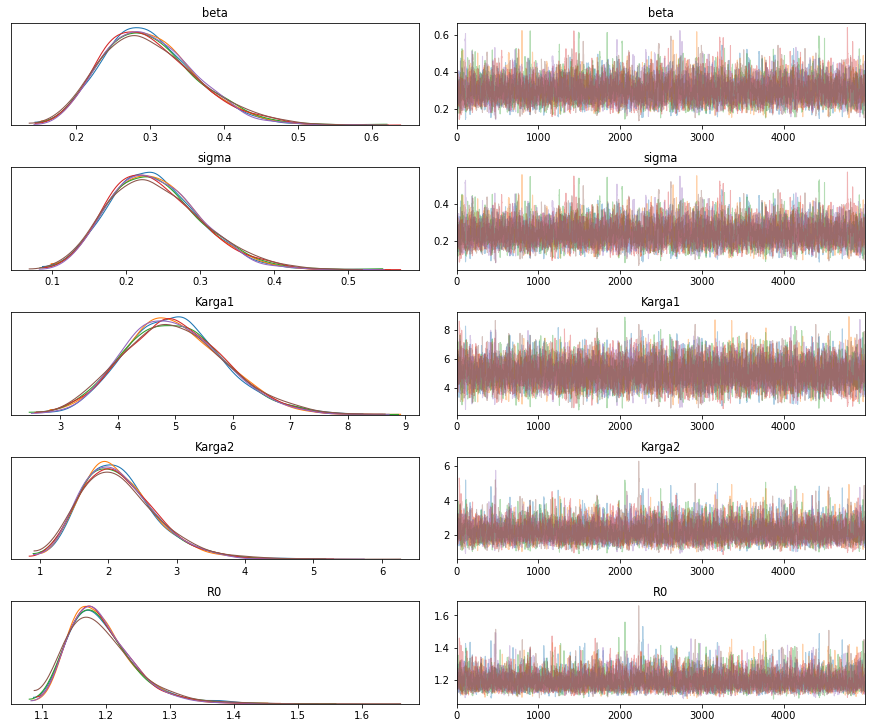

In [18]:
inference_data = az.from_pystan(fit)
plt.figure()
az.plot_trace(inference_data,var_names= varnames)
plt.savefig(save_results_to +'TraceAll.pdf')

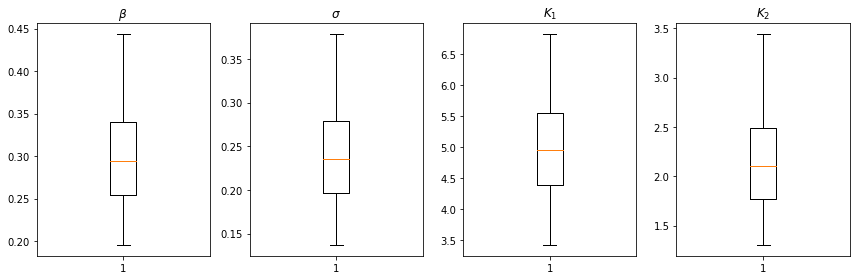

In [19]:
fig, axs = plt.subplots(1, 4,figsize=(12, 4))
axs[0].boxplot(fit_df['beta'],whis=(2.5,97.5), sym='')
axs[0].set_title(r'$\beta$')

axs[1].boxplot(fit_df['sigma'],whis=(2.5,97.5), sym='')
axs[1].set_title(r'$\sigma$')

axs[2].boxplot(fit_df['Karga1'],whis=(2.5,97.5), sym='')
axs[2].set_title(r'$K_1$')

axs[3].boxplot(fit_df['Karga2'],whis=(2.5,97.5), sym='')
axs[3].set_title(r'$K_2$')

plt.tight_layout()
plt.savefig(save_results_to+'Box_Params_CZE.pdf')

In [20]:
median_ppc = np.percentile(fit_dict['fake'],q=50.,axis=0)
CriL_ppc   = np.percentile(fit_dict['fake'],q=2.5,axis=0)
CriU_ppc   = np.percentile(fit_dict['fake'],q=97.5,axis=0)

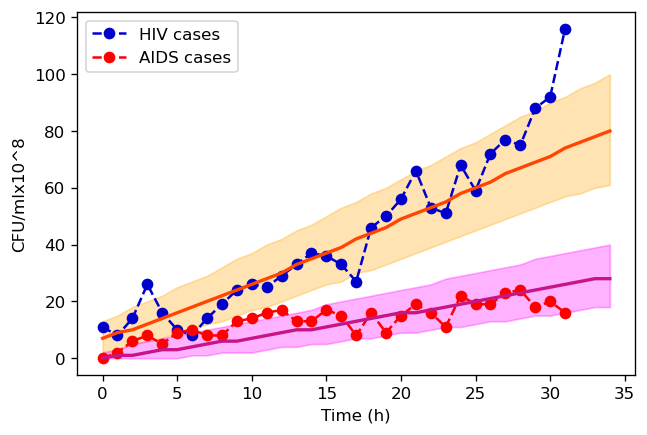

In [21]:
fig, ax = plt.subplots(dpi=120)
ax.plot(times,y_obs[:,0], linestyle='dashed', marker='o', 
        color='mediumblue',label="HIV cases")
ax.plot(times,y_obs[:,1], linestyle='dashed', marker='o', 
        color='red',label="AIDS cases")
ax.plot(times_pred,median_ppc[:,0], color='orangered', lw=2)
ax.plot(times_pred,median_ppc[:,1], color='mediumvioletred', lw=2)
ax.fill_between(times_pred,CriL_ppc[:,0],CriU_ppc[:,0], color='orange', alpha=0.3)
ax.fill_between(times_pred,CriL_ppc[:,1],CriU_ppc[:,1], color='magenta', alpha=0.3)
ax.set_xlabel('Time (h)')  # Add an x-label to the axes.
ax.set_ylabel('CFU/mlx10^8')  # Add a y-label to the axes.
#ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend(loc="upper left")  # Add a legend.
ax.figure.savefig(save_results_to +'PredBands.pdf')

In [22]:
#varnames = ["beta_s", "beta_r",  "delta", "Karga","s0","i0"]
pystan_trace = [fit_dict['beta'], fit_dict['sigma'], fit_dict['Karga1'], fit_dict['Karga2']]

In [23]:
trace=np.array(pystan_trace)
trace_df = pd.DataFrame(pystan_trace) 
map=np.median(trace,axis=1)
range = np.array([(0.5*x,1.5*x) for x in map])

<Figure size 432x288 with 0 Axes>

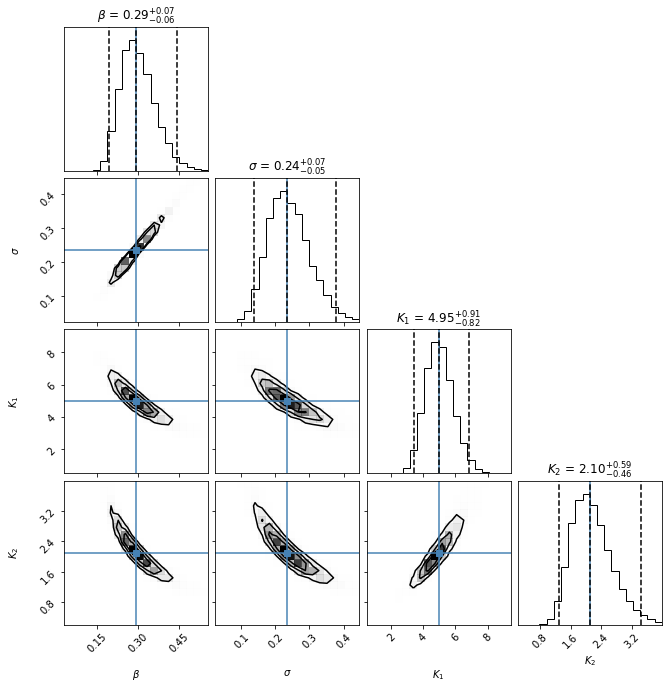

In [24]:
varnames=[r"$\beta$", r"$\sigma$" , r"$K_{1}$" , r"$K_{2}$"]
range = np.array([(0.1*x,1.9*x) for x in map])
plt.figure()
corner.corner(trace_df.T,show_titles=True,labels=varnames,truths=map,range=range,
                    plot_datapoints=False,quantiles=[0.025, 0.5, 0.975])
plt.savefig(save_results_to +'corner2.pdf')

In [25]:
def euclidean(v1, v2):
    return sum((q1-q2)**2 for q1, q2 in zip(v1, v2))**.5

In [26]:
print('Residuals of HIV cases =')
print(euclidean(median_ppc[:,0], y_obs[:,0]))
print('Residuals of AIDS cases =')
print(euclidean(median_ppc[:,1], y_obs[:,1]))
J_H0 = ( 1/len(y_obs[:,0]) ) *(euclidean(median_ppc[:,0], y_obs[:,0]) + euclidean(median_ppc[:,1], y_obs[:,1])  )
print('J_H0 =')
print(J_H0)

Residuals of HIV cases =
63.047601064592456
Residuals of AIDS cases =
27.23967694375247
J_H0 =
2.821477437760779


It follows the code for R0 <= 1

In [27]:
beta_mu = 0.
beta_sd = 1.
beta_stan = 'lognormal({mu}, {sigma})'.format(mu=beta_mu, sigma=beta_sd)


R0_low  = 0
R0_high = 1
R0_stan = 'uniform({mu}, {sd})'.format(mu=R0_low, sd=R0_high)


sigma_low  = 0
sigma_high = 1
sigma_stan = 'uniform({mu}, {sd})'.format(mu=sigma_low, sd=sigma_high)


Karga1_low  = 0
Karga1_high = 30
Karga1_stan = 'uniform({mu}, {sd})'.format(mu=Karga1_low, sd=Karga1_high)


Karga2_low  = 0
Karga2_high = 30
Karga2_stan = 'uniform({mu}, {sd})'.format(mu=Karga2_low, sd=Karga2_high)

In [28]:
# Fit
stan_code = """
functions {{
  real[] SIR(real t,  // time
  real[] y,           // system state {{susceptible,infected,recovered}}
  real[] theta,       // parameters
  real[] x_r,
  int[] x_i) {{
  
  real mu= 0.0089;
  real nu= 0.0129;



  real xi1     =  1e-5;
  real xi2     =  1e-6;
  real kappa  =  0.00003;
  
  real beta   = theta[1];
  real sigma  = theta[2];
  real Karga1 = theta[3];
  real Karga2 = theta[4];
  
  real dy_dt[3];
  
  dy_dt[1] =  mu -(beta*y[2] + nu + xi1  )*y[1];
  dy_dt[2]  =(beta* y[2] + xi1 ) *y[1] - (sigma + nu  - xi2)*y[2];
  dy_dt[3] = (sigma -xi2)* y[2] - (kappa + nu)*y[3];
  
  return dy_dt;
  }}
  
  }}
  data {{
  
  int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_small;       // number of days observed
  int<lower = 1> n_small_pred;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations
  int<lower = 1> n_pop;       // population 
  int y[n_obs,(n_difeq-1)];           // data, total number of infected individuals each day
  real t0;                // initial time point (zero)
  real ts[n_obs];         // time points observed
  real tsm[n_small];         // time points observed
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  real fake_ts[n_small_pred]; // Time points for "predicted"/"unsampled" data
  
  }}
  
  transformed data {{
  real x_r[0];
  int x_i[0];
  }}
  
  parameters {{

//  real<lower =  0, upper = 1.> beta ;
  real<lower =  0, upper = 1.> sigma ;
  real<lower =  0, upper = 1.> R0 ;
  real<lower =  0, upper = 30.> Karga1 ;
  real<lower =  0, upper = 30.> Karga2 ;


  
  }}
  
  transformed parameters{{
  
  real y_hat[n_obs,(n_difeq-1)]; // solution from the ODE solver
  real y_hat_sm[n_small, n_difeq]; // solution from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I
  real theta[n_theta];   // {{ alpha, beta, gamma, delta }}
  
  real S0;
  real I0;
  real A0;
  real lambda1[n_obs];
  real lambda2[n_obs];
  real rho1[n_obs]; 
  real rho2[n_obs];
  vector[11] weights;
  vector[11] incidence1;
  vector[11] incidence2;
  real dt=1./(10*n_obs);
  real xi1=1e-5;
  real xi2=1e-6;  
//  real nu= 0.0129;
  real beta = R0 * (sigma + 0.0129);

  
  S0 = 0.999997301;
  I0 = 0.000002699;
  A0 = 0.;

  y_init[1] = S0;
  y_init[2] = I0;
  y_init[3] = A0;
  
  
  
  
  theta[1] = beta;
  theta[2] = sigma;
  theta[3] = Karga1;
  theta[4] = Karga2;

  
  y_hat_sm = integrate_ode_rk45(SIR, y_init, t0, tsm, theta, x_r, x_i);

  
 weights[1] =0.5;
 weights[11]=0.5;
 
 for (i in 2:10){{
     weights[i] = 1.0;
  }}

 
  for (i in 1:n_obs){{
      lambda1[i] = 0.0;
      lambda2[i] = 0.0;
      for (k in 1:11){{
       incidence1[k] = (beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incidence2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];
       lambda1[i]    = lambda1[i] + dt*weights[k]*incidence1[k];
       lambda2[i]    = lambda2[i] + dt*weights[k]*incidence2[k];
      }}
  y_hat[i,1]=n_pop*Karga1*lambda1[i];
  y_hat[i,2]=n_pop*Karga2*lambda2[i];
 }}
    


  }}
  
  
  model {{
  
  real lamb1[n_obs];      //poisson parameter
  real lamb2[n_obs];      //poisson parameter
  real rhho1[n_obs];      //poisson parameter
  real rhho2[n_obs];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_obs);
  real xii1 =1e-5;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  //priors
//  beta     ~ lognormal(0, 1.);
  R0       ~ uniform(0.0, 1.0 );
  sigma    ~ uniform(0.0, 1.0 );
  Karga1   ~ uniform(0.0, 30 );
  Karga2   ~ uniform(0.0, 30);

  
  
  //likelihood
  for (i in 1:(n_obs)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( beta*y_hat_sm[k + 10*(i-1),2] + xii1 )*y_hat_sm[k + 10*(i-1),1];
       incid2[k] = ( sigma- xii2 )*y_hat_sm[k + 10*(i-1),2];       
       lamb1[i]    = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]    = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i] = n_pop*Karga1*lamb1[i];
  rhho2[i] = n_pop*Karga2*lamb2[i]; 
  y[i , 1] ~ poisson(rhho1[i]);
  y[i , 2] ~ poisson(rhho2[i]);
  }}
 
  }}
  
  generated quantities {{
//  real R_0;      // Basic reproduction number
  real nu= 0.0129;
  real epsilon = 1e-9;
  real fake[n_fake, 2];
  real <lower = 0.> y_hat_pred[n_small_pred, n_difeq]; // Output from the ODE solver
  
  real lamb1[n_fake];      //poisson parameter
  real lamb2[n_fake];      //poisson parameter
  real rhho1[n_fake];      //poisson parameter
  real rhho2[n_fake];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_fake);
  real xii1 =1e-5;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  y_hat_pred = integrate_ode_rk45(SIR, y_init, t0, fake_ts, theta, x_r, x_i);  
  
    //likelihood
  for (i in 1:(n_fake)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( theta[1]*y_hat_pred[k + 10*(i-1),2] + xii1 )*y_hat_pred[k + 10*(i-1),1];
       incid2[k] = ( theta[2]- xii2 )*y_hat_pred[k + 10*(i-1),2];       
       lamb1[i]   = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]   = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i]=n_pop*theta[3]*lamb1[i];
  rhho2[i]=n_pop*theta[4]*lamb2[i];
  fake[i , 1] = poisson_rng( rhho1[i] );
  fake[i , 2] = poisson_rng( rhho2[i] );
 
  }}
  
  
//  R_0 = theta[1]/(theta[2] + nu);
  }}
""".format(
        R0     =R0_stan,
        sigma  =sigma_stan,
        Karga1 =Karga1_stan,
        Karga2 =Karga2_stan
        )

In [29]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_542de0325d819222bb0f01f0ccb09ab7 NOW.


--- 50.50296401977539 seconds ---


In [30]:
# do the fitting
start_time = time.time()
fit = sm.sampling(
                  data=mydata,
                  iter=NumIter,
                  chains=6,
                  warmup=burnin,
                  seed=431,
                  verbose=True,
                  algorithm='NUTS',
                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--- 90.19692730903625 seconds ---


In [31]:
#varnames = ["beta", "sigma", "Karga1", "Karga2"]
varnames = ["beta", "sigma", "Karga1", "Karga2","R0"]
summary=fit.summary(pars=varnames, probs=(0.025, 0.25, 0.5, 0.75, 0.975))

In [32]:
df_summary =  pd.DataFrame(
    summary['summary'],
    columns=summary['summary_colnames'],
    index=summary['summary_rownames']
)

fit_dict= fit.extract()
fit_df = fit.to_dataframe()

In [33]:
fit_dict= fit.extract()
fit_df = fit.to_dataframe()
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,0.264809,0.000408,0.035791,0.200123,0.239871,0.262841,0.287913,0.339940,7693.454216,1.000460
sigma,0.252828,0.000407,0.035810,0.188083,0.227859,0.250862,0.275999,0.328210,7729.177143,1.000470
Karga1,8.155065,0.008761,0.767090,6.757698,7.617086,8.114351,8.649986,9.768290,7667.090873,1.000594
Karga2,3.264897,0.004979,0.438550,2.516002,2.954926,3.227428,3.533120,4.228130,7757.553406,1.000447
R0,0.996498,0.000029,0.003532,0.987035,0.995148,0.997577,0.998999,0.999913,14839.101836,1.000394


In [34]:
data = az.from_pystan(
    posterior=fit,
    posterior_predictive="fake",
    observed_data=["y"],
)

data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> observed_data

<Figure size 432x288 with 0 Axes>

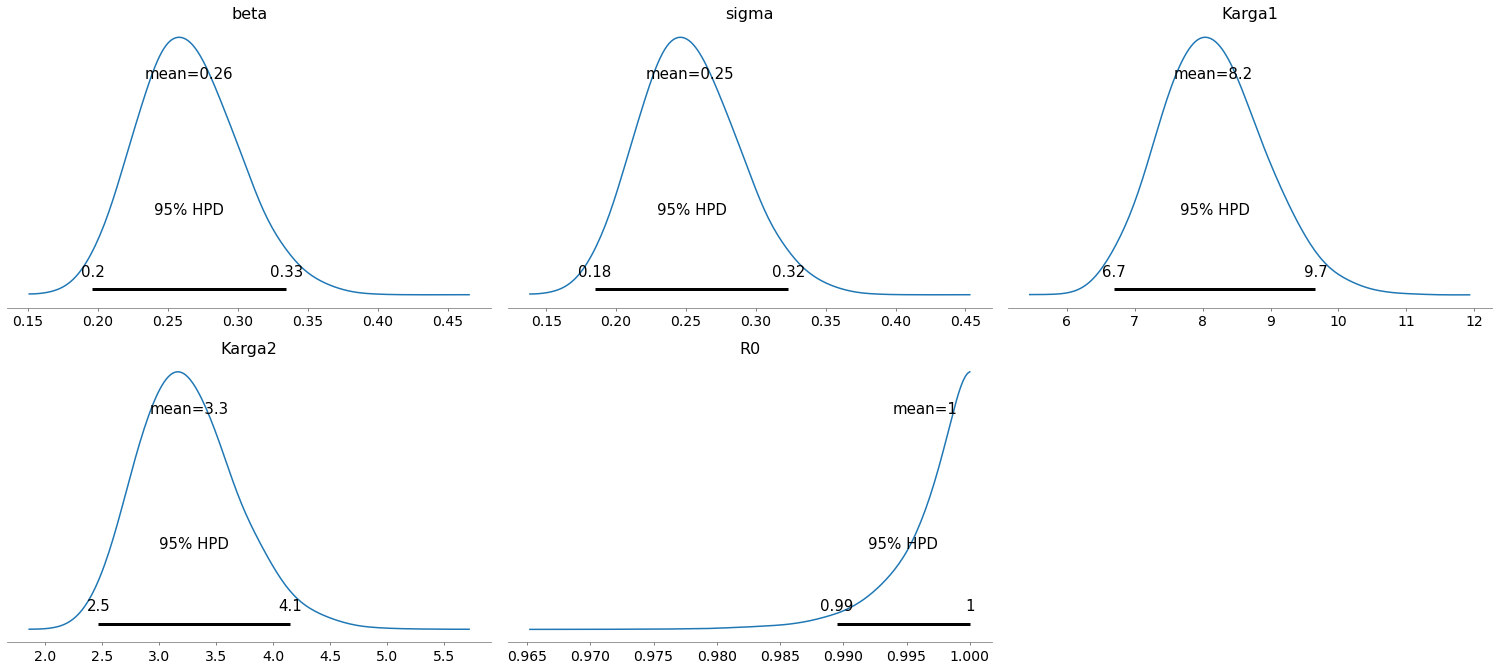

In [35]:
fig =plt.figure()
az.plot_posterior(data,var_names=varnames,credible_interval=0.95);
plt.savefig(save_results_to + 'credibleIntervalsAll_alt.eps')

In [36]:
median_ppc = np.percentile(fit_dict['fake'],q=50.,axis=0)
CriL_ppc   = np.percentile(fit_dict['fake'],q=2.5,axis=0)
CriU_ppc   = np.percentile(fit_dict['fake'],q=97.5,axis=0)

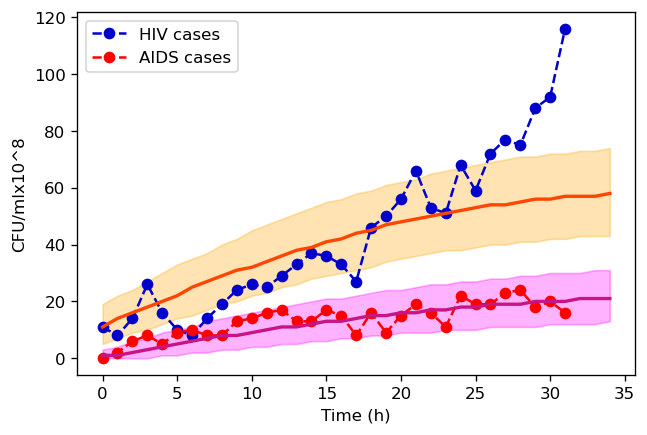

In [37]:
fig, ax = plt.subplots(dpi=120)
ax.plot(times,y_obs[:,0], linestyle='dashed', marker='o', 
        color='mediumblue',label="HIV cases")
ax.plot(times,y_obs[:,1], linestyle='dashed', marker='o', 
        color='red',label="AIDS cases")
ax.plot(times_pred,median_ppc[:,0], color='orangered', lw=2)
ax.plot(times_pred,median_ppc[:,1], color='mediumvioletred', lw=2)
ax.fill_between(times_pred,CriL_ppc[:,0],CriU_ppc[:,0], color='orange', alpha=0.3)
ax.fill_between(times_pred,CriL_ppc[:,1],CriU_ppc[:,1], color='magenta', alpha=0.3)
ax.set_xlabel('Time (h)')  # Add an x-label to the axes.
ax.set_ylabel('CFU/mlx10^8')  # Add a y-label to the axes.
#ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend(loc="upper left")  # Add a legend.
ax.figure.savefig(save_results_to +'PredBands_alt.pdf')

In [38]:
print('Residuals of HIV cases =')
print(euclidean(median_ppc[:,0], y_obs[:,0]))
print('Residuals of AIDS cases =')
print(euclidean(median_ppc[:,1], y_obs[:,1]))
#J_H1 = ( 1/len(y_obs[:,0]) ) *(euclidean(median_ppc[:,0], y_obs[:,0]) + euclidean(median_ppc[:,1], y_obs[:,1]) )
J_H1 = (euclidean(median_ppc[:,0], y_obs[:,0]) + euclidean(median_ppc[:,1], y_obs[:,1])  )
print('J_H1 =')
print(J_H1)

Residuals of HIV cases =
95.8070978581441
Residuals of AIDS cases =
20.54263858417414
J_H1 =
116.34973644231825


In [41]:
#U=( J_H1-J_H0 )/J_H1
U=( len(y_obs[:,0]) ) *( J_H1-101.9127833 )/J_H1
U

3.970636416380858